In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import transforms
from torch.utils.data import DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle


In [2]:
torch.cuda.is_available()


True

In [3]:
DATA_PATH = "D:/Coding/data/astro_dataset_maxia/astro_dataset_maxia"

**1 Hidden Layer w/o Greyscale**

In [80]:

eval_transform = train_transform = transforms.Compose([transforms.Resize((128, 128)), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                           std=[0.5, 0.5, 0.5]),                     
])

In [81]:
train_data = datasets.ImageFolder(os.path.join(DATA_PATH, "training"), transform=train_transform)
test_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "test"), transform=eval_transform)
val_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "validation"), transform=eval_transform)

print("Classes:", train_data.classes)
print("Number of Classes:", len(train_data.classes))
print("Training Samples:", len(train_data))
print("Val Samples:", len(val_data))
print("Test Samples:", len(test_data))
print("Total Samples:", len(train_data)+len(val_data)+len(test_data))

Classes: ['asteroid', 'black_hole', 'earth', 'galaxy', 'jupiter', 'mars', 'mercury', 'neptune', 'pluto', 'saturn', 'uranus', 'venus']
Number of Classes: 12
Training Samples: 2416
Val Samples: 658
Test Samples: 345
Total Samples: 3419


In [13]:
img, label = train_data[0]
print(img.shape)


torch.Size([3, 128, 128])


In [67]:
class ANN(nn.Module):
    def __init__(self, input_size = 3*128*128, num_classes = 12, dropout = 0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [82]:
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True)

val_loader = DataLoader(val_data,
                        batch_size=32,
                        shuffle=False,
                        pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=False,
                         pin_memory=True)


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = ANN().to(device)

In [17]:
#MSE issues for classification: gradients become small convergence becomes slow probabilities don’t normalize accuracy is worse
learning_rate = 0.001
weight_decay = lamb = 0.0001



In [69]:
def train_ann(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001, weight_decay=0.0001):
    model = ANN().to(device)
    print("Training on: ", device)

    crieterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    weight_decay=weight_decay
    )
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(images)
            loss = crieterion(outputs, labels)

            loss.backward()
            optimiser.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted =  torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        avg_train_loss = running_loss/total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0 
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = crieterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100 * val_correct/val_total
        avg_val_loss = val_loss/val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
            f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        )
    print("Training_complete")
    return model, history

    

In [20]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay=0.0001
)

Training on:  cuda
Epoch [1/20] Train Loss: 8.9053 | Val Loss: 4.5843 | Train Acc: 32.5745 | Val Acc: 45.5927
Epoch [2/20] Train Loss: 3.9640 | Val Loss: 3.1736 | Train Acc: 45.9437 | Val Acc: 60.9422
Epoch [3/20] Train Loss: 3.0867 | Val Loss: 3.2045 | Train Acc: 49.0480 | Val Acc: 58.5106
Epoch [4/20] Train Loss: 2.9099 | Val Loss: 3.1816 | Train Acc: 53.8079 | Val Acc: 64.1337
Epoch [5/20] Train Loss: 2.3710 | Val Loss: 3.5837 | Train Acc: 58.3195 | Val Acc: 65.6535
Epoch [6/20] Train Loss: 2.2866 | Val Loss: 3.9236 | Train Acc: 56.6639 | Val Acc: 65.0456
Epoch [7/20] Train Loss: 2.6965 | Val Loss: 2.2955 | Train Acc: 58.0298 | Val Acc: 68.2371
Epoch [8/20] Train Loss: 2.4427 | Val Loss: 3.8778 | Train Acc: 60.2649 | Val Acc: 74.7720
Epoch [9/20] Train Loss: 2.1418 | Val Loss: 3.7022 | Train Acc: 61.7964 | Val Acc: 71.2766
Epoch [10/20] Train Loss: 2.5866 | Val Loss: 3.4298 | Train Acc: 60.9685 | Val Acc: 65.0456
Epoch [11/20] Train Loss: 1.6929 | Val Loss: 2.7535 | Train Acc: 62.83

In [23]:
trained_ann

(ANN(
   (model): Sequential(
     (0): Linear(in_features=49152, out_features=256, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.3, inplace=False)
     (3): Linear(in_features=256, out_features=12, bias=True)
   )
 ),
 {'train_loss': [8.905284302124125,
   3.964023267985969,
   3.086694468725596,
   2.909925048714442,
   2.3710431176305606,
   2.286629599451229,
   2.6965144027937327,
   2.442651358661273,
   2.141841246592288,
   2.5866221323708034,
   1.6928853617598678,
   2.410285285766551,
   3.089131504494623,
   2.3903963743456154,
   2.2506402667784533,
   1.9367957959901418,
   1.8494753920479325,
   1.682248335010958,
   2.20801278613261,
   2.3626741155093867],
  'val_loss': [4.584280325648995,
   3.1736304865057345,
   3.2044577902030076,
   3.181635107856391,
   3.583671898646195,
   3.923589053668512,
   2.295486271698424,
   3.877783906405458,
   3.7021590126140502,
   3.4297745431628996,
   2.753484223479558,
   4.641350150357445,
   2.3841601041312637,
   4.023580

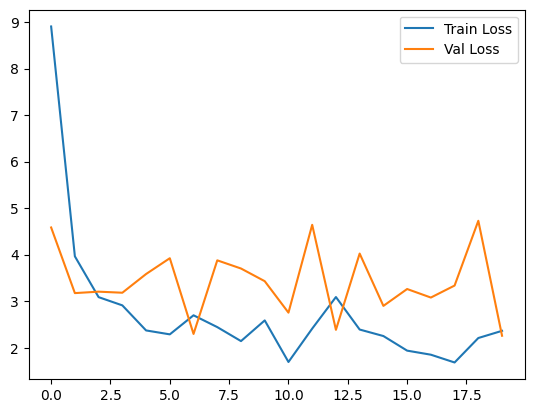

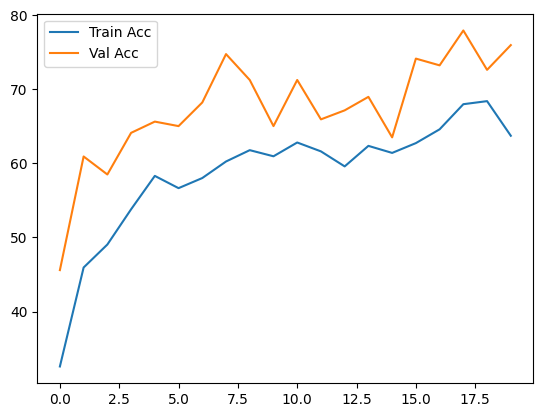

In [24]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [26]:
os.makedirs("saved_models", exist_ok=True)
torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_1e-4.pth" )

In [27]:
import pickle
with open("saved_models/ann_lambda_1e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

We can see that its underfitting therefore let's slighltly decrease the lambda. 

This is expected since the model wiht one hidden layer is too simple to detect underlying patterns

In [33]:
lamb = 0.00001

In [34]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 8.0266 | Val Loss: 3.2201 | Train Acc: 32.9470 | Val Acc: 50.1520
Epoch [2/20] Train Loss: 3.1400 | Val Loss: 2.3765 | Train Acc: 45.5712 | Val Acc: 58.6626
Epoch [3/20] Train Loss: 3.1833 | Val Loss: 2.7000 | Train Acc: 51.5315 | Val Acc: 71.1246
Epoch [4/20] Train Loss: 2.8966 | Val Loss: 3.7543 | Train Acc: 50.6209 | Val Acc: 62.1581
Epoch [5/20] Train Loss: 2.5572 | Val Loss: 2.3727 | Train Acc: 56.4570 | Val Acc: 66.1094
Epoch [6/20] Train Loss: 3.0596 | Val Loss: 3.7519 | Train Acc: 56.6639 | Val Acc: 61.3982
Epoch [7/20] Train Loss: 3.2333 | Val Loss: 3.2044 | Train Acc: 55.1325 | Val Acc: 71.4286
Epoch [8/20] Train Loss: 2.3802 | Val Loss: 3.4478 | Train Acc: 60.8858 | Val Acc: 72.7964
Epoch [9/20] Train Loss: 2.2924 | Val Loss: 3.7180 | Train Acc: 61.7550 | Val Acc: 68.0851
Epoch [10/20] Train Loss: 2.2946 | Val Loss: 4.1560 | Train Acc: 61.7136 | Val Acc: 66.5653
Epoch [11/20] Train Loss: 2.1123 | Val Loss: 4.2183 | Train Acc: 63.57

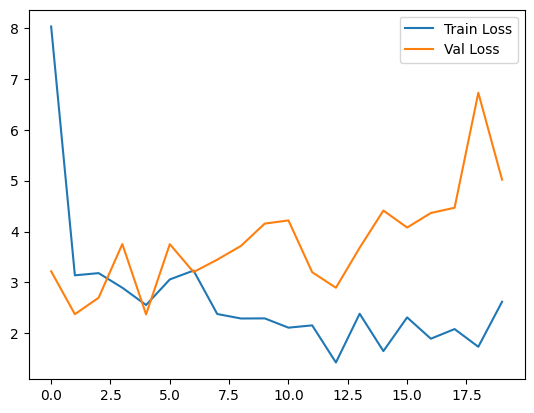

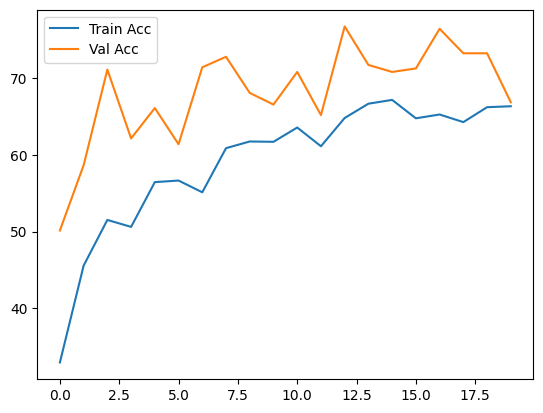

In [38]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [ ]:

torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_1e-5.pth" )

In [40]:
with open("saved_models/ann_lambda_1e-5_history.pkl", "wb") as f:
    pickle.dump(history, f)

Since the lambda is smaller, volatility increased, we also see a slight increase in accuracy. Let's see what happens when go to a smaller lambda

In [27]:
lamb = 0.000005

In [28]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 7.9561 | Val Loss: 4.7946 | Train Acc: 32.6573 | Val Acc: 51.6717
Epoch [2/20] Train Loss: 4.2591 | Val Loss: 2.4946 | Train Acc: 45.6126 | Val Acc: 59.7264
Epoch [3/20] Train Loss: 2.7096 | Val Loss: 3.2242 | Train Acc: 51.5315 | Val Acc: 67.0213
Epoch [4/20] Train Loss: 2.7248 | Val Loss: 2.4980 | Train Acc: 52.4421 | Val Acc: 60.3343
Epoch [5/20] Train Loss: 2.6443 | Val Loss: 2.9176 | Train Acc: 56.0017 | Val Acc: 63.2219
Epoch [6/20] Train Loss: 2.3066 | Val Loss: 3.9694 | Train Acc: 54.8427 | Val Acc: 63.6778
Epoch [7/20] Train Loss: 3.5896 | Val Loss: 5.0121 | Train Acc: 54.7185 | Val Acc: 56.8389
Epoch [8/20] Train Loss: 2.5956 | Val Loss: 2.9742 | Train Acc: 55.5877 | Val Acc: 65.9574
Epoch [9/20] Train Loss: 2.3231 | Val Loss: 3.1984 | Train Acc: 56.6225 | Val Acc: 63.8298
Epoch [10/20] Train Loss: 2.2911 | Val Loss: 4.2717 | Train Acc: 59.6026 | Val Acc: 72.7964
Epoch [11/20] Train Loss: 1.9011 | Val Loss: 3.8653 | Train Acc: 63.53

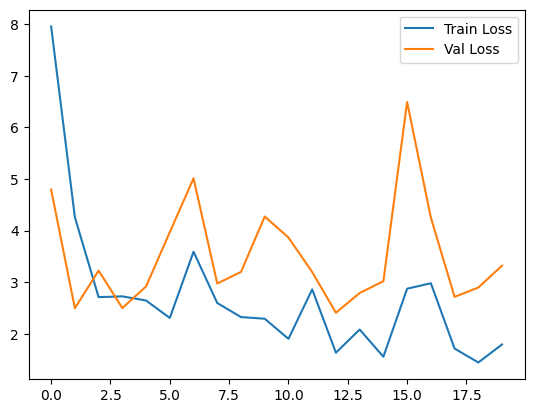

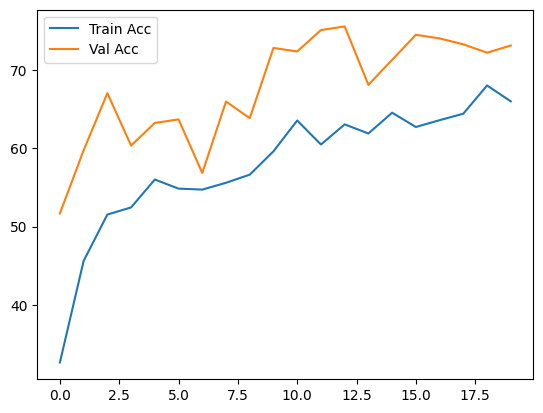

In [29]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [31]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_5e-6.pth" )

In [32]:
with open("saved_models/ann_lambda_5e-6_history.pkl", "wb") as f:
    pickle.dump(history, f)

What happens when we remove regularizations?

In [19]:
lamb = 0

In [20]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 8.1223 | Val Loss: 2.4513 | Train Acc: 33.5265 | Val Acc: 50.9119
Epoch [2/20] Train Loss: 4.1194 | Val Loss: 3.3940 | Train Acc: 45.8195 | Val Acc: 53.4954
Epoch [3/20] Train Loss: 2.8559 | Val Loss: 3.1562 | Train Acc: 52.7318 | Val Acc: 58.2067
Epoch [4/20] Train Loss: 3.0121 | Val Loss: 3.0723 | Train Acc: 54.2632 | Val Acc: 69.4529
Epoch [5/20] Train Loss: 2.5343 | Val Loss: 3.5671 | Train Acc: 55.7533 | Val Acc: 65.8055
Epoch [6/20] Train Loss: 2.9564 | Val Loss: 2.8228 | Train Acc: 57.5745 | Val Acc: 66.1094
Epoch [7/20] Train Loss: 2.9196 | Val Loss: 4.0068 | Train Acc: 58.1126 | Val Acc: 68.0851
Epoch [8/20] Train Loss: 2.5112 | Val Loss: 3.4167 | Train Acc: 63.6175 | Val Acc: 65.0456
Epoch [9/20] Train Loss: 2.1092 | Val Loss: 2.3281 | Train Acc: 61.1755 | Val Acc: 63.9818
Epoch [10/20] Train Loss: 2.4977 | Val Loss: 2.5018 | Train Acc: 62.2103 | Val Acc: 73.1003
Epoch [11/20] Train Loss: 1.9031 | Val Loss: 3.4799 | Train Acc: 61.96

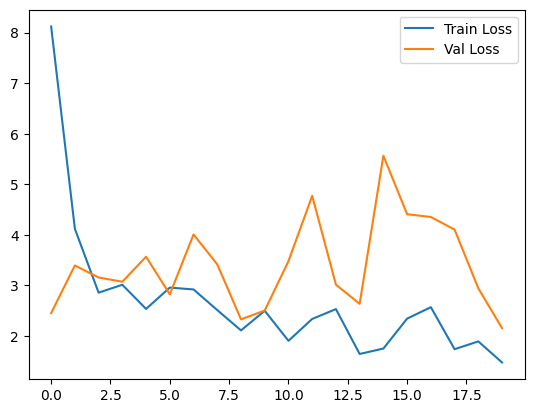

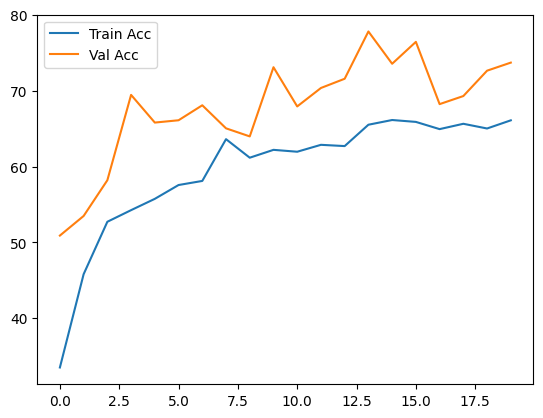

In [21]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [22]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_0.pth")

In [24]:
import pickle
with open("saved_models/ann_lambda_0_history.pkl", "wb") as f:
    pickle.dump(history, f)

On the Contrary let's see what happens when we increase lambda

In [25]:
lamb = 0.0005

In [26]:
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 8.6044 | Val Loss: 3.4318 | Train Acc: 31.4983 | Val Acc: 47.8723
Epoch [2/20] Train Loss: 3.7718 | Val Loss: 3.5951 | Train Acc: 43.7914 | Val Acc: 56.6869
Epoch [3/20] Train Loss: 3.4064 | Val Loss: 4.8009 | Train Acc: 50.0828 | Val Acc: 60.3343
Epoch [4/20] Train Loss: 2.9848 | Val Loss: 2.0565 | Train Acc: 55.1325 | Val Acc: 69.6049
Epoch [5/20] Train Loss: 2.6748 | Val Loss: 2.8277 | Train Acc: 57.4089 | Val Acc: 70.3647
Epoch [6/20] Train Loss: 2.0166 | Val Loss: 3.2851 | Train Acc: 61.2169 | Val Acc: 67.9331
Epoch [7/20] Train Loss: 2.4025 | Val Loss: 3.1831 | Train Acc: 58.4437 | Val Acc: 61.8541
Epoch [8/20] Train Loss: 2.4513 | Val Loss: 2.7381 | Train Acc: 60.9272 | Val Acc: 67.0213
Epoch [9/20] Train Loss: 2.0944 | Val Loss: 3.6580 | Train Acc: 62.1689 | Val Acc: 66.2614
Epoch [10/20] Train Loss: 1.9234 | Val Loss: 2.8061 | Train Acc: 62.2103 | Val Acc: 71.5805
Epoch [11/20] Train Loss: 2.2429 | Val Loss: 3.7378 | Train Acc: 62.33

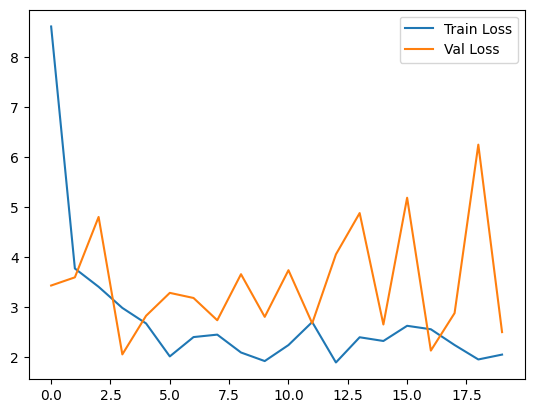

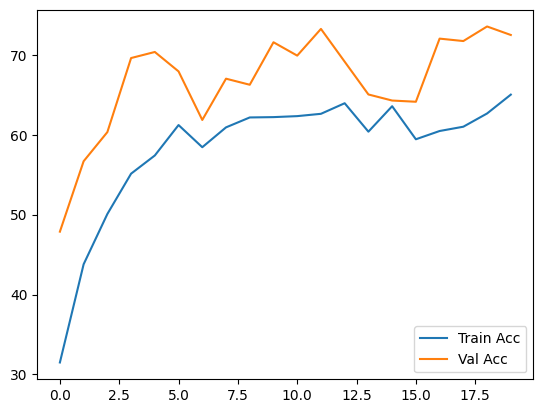

In [27]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [28]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_5e-4.pth")

In [29]:
with open("saved_models/ann_lambda_5e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

Let's try one with a lower learning rate and higher lambda

In [70]:
lamb = 0.001
ann_model = ANN()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.0001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.9067 | Val Loss: 1.2120 | Train Acc: 41.8874 | Val Acc: 67.0213
Epoch [2/20] Train Loss: 1.3252 | Val Loss: 1.1497 | Train Acc: 57.6573 | Val Acc: 68.8450
Epoch [3/20] Train Loss: 1.1755 | Val Loss: 1.0108 | Train Acc: 62.2517 | Val Acc: 75.2280
Epoch [4/20] Train Loss: 1.0813 | Val Loss: 0.9462 | Train Acc: 65.3974 | Val Acc: 74.7720
Epoch [5/20] Train Loss: 0.9848 | Val Loss: 0.8261 | Train Acc: 70.3642 | Val Acc: 79.9392
Epoch [6/20] Train Loss: 0.8955 | Val Loss: 0.8587 | Train Acc: 72.1440 | Val Acc: 78.4195
Epoch [7/20] Train Loss: 0.8237 | Val Loss: 0.7914 | Train Acc: 74.0480 | Val Acc: 80.6991
Epoch [8/20] Train Loss: 0.7827 | Val Loss: 0.9339 | Train Acc: 76.2417 | Val Acc: 74.9240
Epoch [9/20] Train Loss: 0.7698 | Val Loss: 0.7535 | Train Acc: 77.6904 | Val Acc: 81.9149
Epoch [10/20] Train Loss: 0.7151 | Val Loss: 0.7607 | Train Acc: 78.3113 | Val Acc: 83.8906
Epoch [11/20] Train Loss: 0.6581 | Val Loss: 0.7584 | Train Acc: 79.38

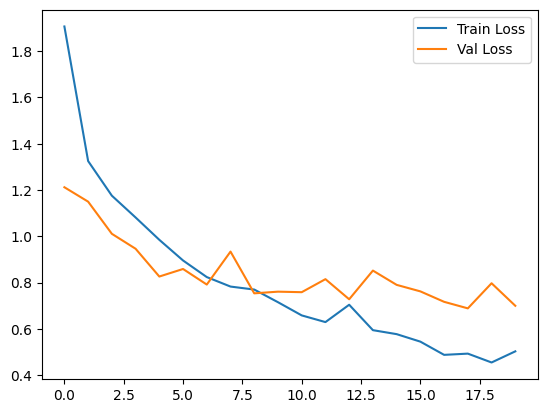

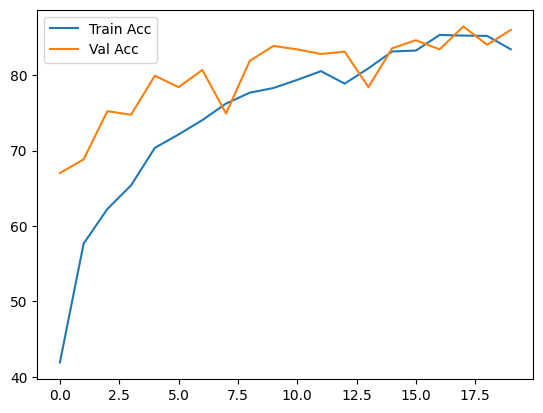

In [71]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [72]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann_lambda_1e-3.pth")

In [73]:
with open("saved_models/ann_lambda_1e-3_history.pkl", "wb") as f:
    pickle.dump(history, f)

**1 Hidden Layer w/ greyscale**

In [5]:

eval_transform = train_transform = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5], std=[0.5])                     
])

In [6]:
train_data = datasets.ImageFolder(os.path.join(DATA_PATH, "training"), transform=train_transform)
test_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "test"), transform=eval_transform)
val_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "validation"), transform=eval_transform)

print("Classes:", train_data.classes)
print("Number of Classes:", len(train_data.classes))
print("Training Samples:", len(train_data))
print("Val Samples:", len(val_data))
print("Test Samples:", len(test_data))
print("Total Samples:", len(train_data)+len(val_data)+len(test_data))

Classes: ['asteroid', 'black_hole', 'earth', 'galaxy', 'jupiter', 'mars', 'mercury', 'neptune', 'pluto', 'saturn', 'uranus', 'venus']
Number of Classes: 12
Training Samples: 2416
Val Samples: 658
Test Samples: 345
Total Samples: 3419


In [40]:
class ANN2(nn.Module):
    def __init__(self, input_size = 128*128, num_classes = 12, dropout = 0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [8]:
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True)

val_loader = DataLoader(val_data,
                        batch_size=32,
                        shuffle=False,
                        pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=False,
                         pin_memory=True)


In [9]:
learning_rate = 0.001
weight_decay = lamb = 0.0001

In [10]:
def train_ann(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001, weight_decay=0.0001):
    model = ANN2().to(device)
    print("Training on: ", device)

    crieterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    weight_decay=weight_decay
    )
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(images)
            loss = crieterion(outputs, labels)

            loss.backward()
            optimiser.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted =  torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        avg_train_loss = running_loss/total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0 
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = crieterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100 * val_correct/val_total
        avg_val_loss = val_loss/val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
            f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        )
    print("Training_complete")
    return model, history

    

In [66]:
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 4.1681 | Val Loss: 3.2464 | Train Acc: 25.2070 | Val Acc: 34.1945
Epoch [2/20] Train Loss: 2.7451 | Val Loss: 2.4813 | Train Acc: 35.8444 | Val Acc: 39.5137
Epoch [3/20] Train Loss: 2.3067 | Val Loss: 2.1311 | Train Acc: 39.3626 | Val Acc: 54.2553
Epoch [4/20] Train Loss: 2.3591 | Val Loss: 2.2422 | Train Acc: 44.1225 | Val Acc: 48.1763
Epoch [5/20] Train Loss: 2.0882 | Val Loss: 1.9920 | Train Acc: 44.3709 | Val Acc: 54.4073
Epoch [6/20] Train Loss: 2.0370 | Val Loss: 1.8864 | Train Acc: 45.2401 | Val Acc: 51.5198
Epoch [7/20] Train Loss: 2.1385 | Val Loss: 1.9145 | Train Acc: 47.2268 | Val Acc: 57.5988
Epoch [8/20] Train Loss: 1.9127 | Val Loss: 1.9573 | Train Acc: 51.2003 | Val Acc: 60.9422
Epoch [9/20] Train Loss: 1.7944 | Val Loss: 1.8487 | Train Acc: 52.6904 | Val Acc: 61.5502
Epoch [10/20] Train Loss: 1.8333 | Val Loss: 1.8190 | Train Acc: 53.5182 | Val Acc: 58.8146
Epoch [11/20] Train Loss: 1.7895 | Val Loss: 2.4863 | Train Acc: 53.89

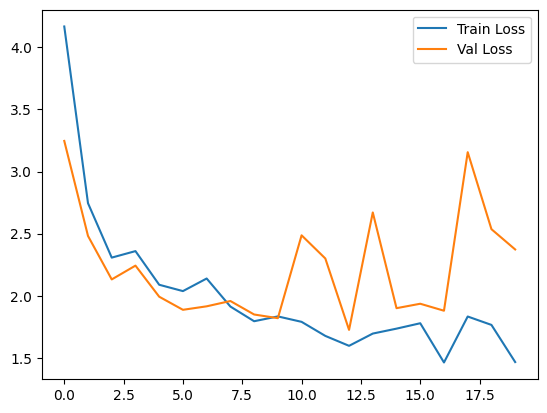

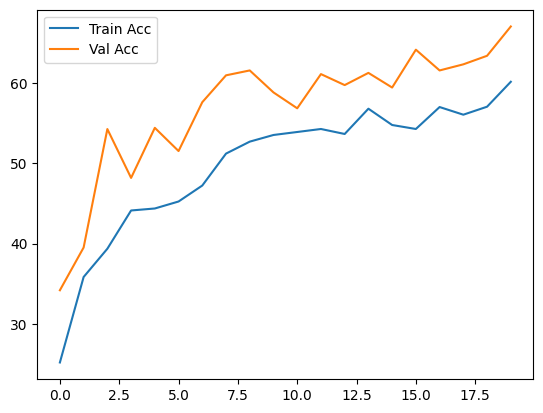

In [67]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [68]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_1e-4.pth")

In [69]:
with open("saved_models/ann-grey_lambda_1e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

Underfitting lets try a smaller lambda

In [15]:
lamb = 0.00001
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 4.4362 | Val Loss: 2.7796 | Train Acc: 25.9520 | Val Acc: 37.8419
Epoch [2/20] Train Loss: 2.7258 | Val Loss: 2.6624 | Train Acc: 36.2997 | Val Acc: 41.9453
Epoch [3/20] Train Loss: 2.2729 | Val Loss: 2.7376 | Train Acc: 42.8808 | Val Acc: 48.9362
Epoch [4/20] Train Loss: 2.2901 | Val Loss: 2.1249 | Train Acc: 43.0464 | Val Acc: 51.3678
Epoch [5/20] Train Loss: 2.0688 | Val Loss: 2.0755 | Train Acc: 47.4752 | Val Acc: 47.5684
Epoch [6/20] Train Loss: 1.9619 | Val Loss: 2.8483 | Train Acc: 45.0745 | Val Acc: 52.8875
Epoch [7/20] Train Loss: 1.9277 | Val Loss: 2.4682 | Train Acc: 47.5579 | Val Acc: 53.6474
Epoch [8/20] Train Loss: 1.7690 | Val Loss: 1.8969 | Train Acc: 49.3377 | Val Acc: 58.0547
Epoch [9/20] Train Loss: 1.8305 | Val Loss: 2.3663 | Train Acc: 51.3245 | Val Acc: 58.8146
Epoch [10/20] Train Loss: 1.7551 | Val Loss: 1.9926 | Train Acc: 54.2632 | Val Acc: 62.4620
Epoch [11/20] Train Loss: 1.7376 | Val Loss: 1.9759 | Train Acc: 53.47

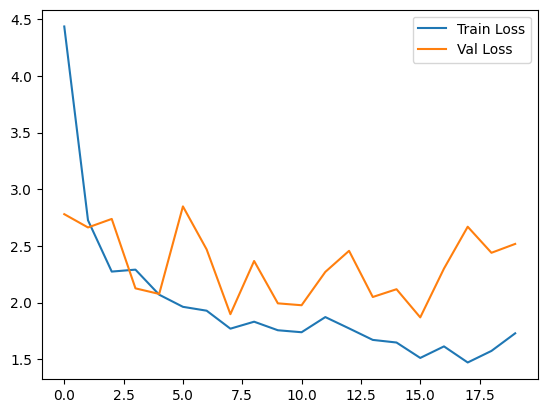

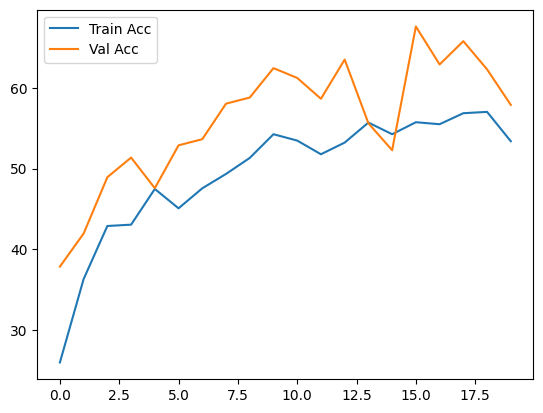

In [16]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [17]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_1e-5.pth")

In [18]:
with open("saved_models/ann-grey_lambda_1e-5_history.pkl", "wb") as f:
    pickle.dump(history, f)

it seems like lowering the lambda reduced accurracy. lets try something in between

In [19]:
lamb = 0.00005
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 3.5884 | Val Loss: 2.1372 | Train Acc: 27.8146 | Val Acc: 38.6018
Epoch [2/20] Train Loss: 2.5559 | Val Loss: 2.3782 | Train Acc: 37.4586 | Val Acc: 48.3283
Epoch [3/20] Train Loss: 2.3887 | Val Loss: 2.1874 | Train Acc: 40.8940 | Val Acc: 44.5289
Epoch [4/20] Train Loss: 2.2745 | Val Loss: 2.3365 | Train Acc: 42.4255 | Val Acc: 48.1763
Epoch [5/20] Train Loss: 2.1915 | Val Loss: 1.9717 | Train Acc: 44.2467 | Val Acc: 56.3830
Epoch [6/20] Train Loss: 2.0945 | Val Loss: 2.2532 | Train Acc: 47.3096 | Val Acc: 49.8480
Epoch [7/20] Train Loss: 1.7953 | Val Loss: 2.0843 | Train Acc: 47.9719 | Val Acc: 59.1185
Epoch [8/20] Train Loss: 1.8538 | Val Loss: 2.1142 | Train Acc: 49.9586 | Val Acc: 55.0152
Epoch [9/20] Train Loss: 1.8725 | Val Loss: 2.2516 | Train Acc: 48.8825 | Val Acc: 53.9514
Epoch [10/20] Train Loss: 1.8396 | Val Loss: 2.2717 | Train Acc: 51.6970 | Val Acc: 62.7660
Epoch [11/20] Train Loss: 1.8356 | Val Loss: 2.3224 | Train Acc: 51.49

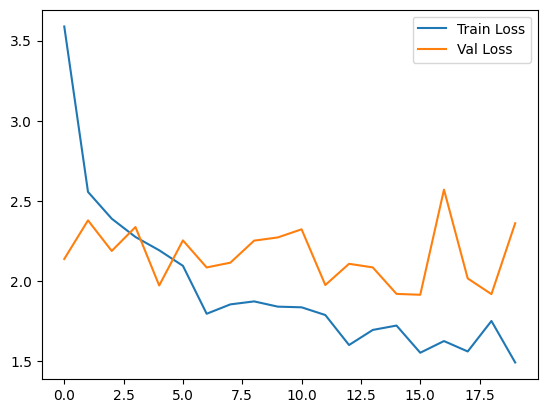

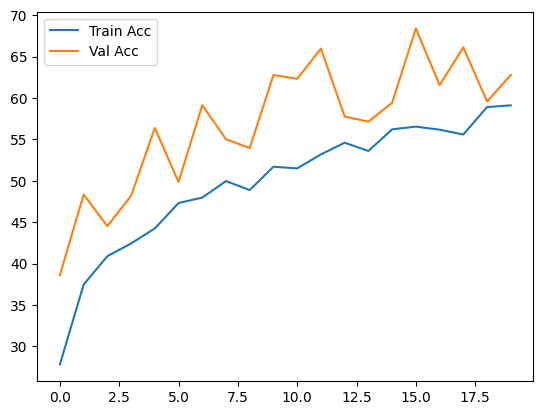

In [20]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [ ]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_5e-5.pth")

In [ ]:
with open("saved_models/ann-grey_lambda_5e-5_history.pkl", "wb") as f:
    pickle.dump(history, f)

Seems like the accuracy improved. Let's try something betweeen both


In [23]:
lamb = 0.000075
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 3.7607 | Val Loss: 3.0876 | Train Acc: 27.4421 | Val Acc: 31.4590
Epoch [2/20] Train Loss: 2.7228 | Val Loss: 2.8242 | Train Acc: 37.6242 | Val Acc: 45.2888
Epoch [3/20] Train Loss: 2.5981 | Val Loss: 2.1796 | Train Acc: 41.2666 | Val Acc: 45.5927
Epoch [4/20] Train Loss: 2.4388 | Val Loss: 2.1817 | Train Acc: 43.0050 | Val Acc: 48.7842
Epoch [5/20] Train Loss: 2.2581 | Val Loss: 2.1007 | Train Acc: 45.7781 | Val Acc: 51.2158
Epoch [6/20] Train Loss: 2.5439 | Val Loss: 2.0594 | Train Acc: 45.9851 | Val Acc: 49.0881
Epoch [7/20] Train Loss: 1.8445 | Val Loss: 2.1210 | Train Acc: 47.6821 | Val Acc: 53.1915
Epoch [8/20] Train Loss: 1.7950 | Val Loss: 1.9254 | Train Acc: 49.4619 | Val Acc: 49.5441
Epoch [9/20] Train Loss: 1.9774 | Val Loss: 2.2699 | Train Acc: 46.0679 | Val Acc: 48.1763
Epoch [10/20] Train Loss: 1.8341 | Val Loss: 2.6981 | Train Acc: 49.3377 | Val Acc: 57.9027
Epoch [11/20] Train Loss: 1.8281 | Val Loss: 2.3483 | Train Acc: 51.94

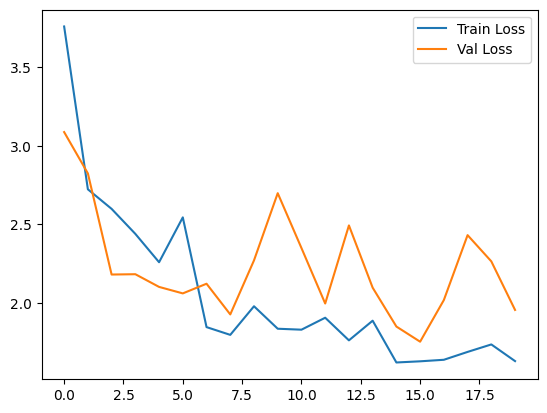

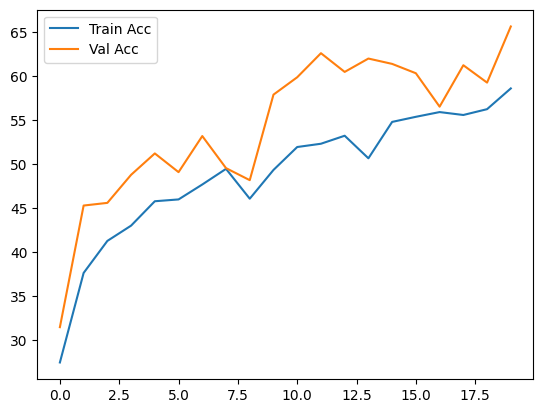

In [24]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [25]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_7_5e-5.pth")

In [26]:
with open("saved_models/ann-grey_lambda_7_5e-5_history.pkl", "wb") as f:
    pickle.dump(history, f)

It doesn't seem like we are better 1e-4's accuracy. Let's try something larger

In [27]:
lamb = 0.001
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 4.1809 | Val Loss: 2.8122 | Train Acc: 25.7864 | Val Acc: 35.7143
Epoch [2/20] Train Loss: 2.7572 | Val Loss: 2.6344 | Train Acc: 35.2235 | Val Acc: 40.1216
Epoch [3/20] Train Loss: 2.4092 | Val Loss: 2.0249 | Train Acc: 38.4106 | Val Acc: 39.0578
Epoch [4/20] Train Loss: 2.1840 | Val Loss: 2.6466 | Train Acc: 42.7152 | Val Acc: 48.9362
Epoch [5/20] Train Loss: 2.2359 | Val Loss: 1.7429 | Train Acc: 42.8808 | Val Acc: 55.9271
Epoch [6/20] Train Loss: 2.1002 | Val Loss: 2.2870 | Train Acc: 47.2268 | Val Acc: 50.4559
Epoch [7/20] Train Loss: 2.0477 | Val Loss: 2.4128 | Train Acc: 45.8195 | Val Acc: 54.5593
Epoch [8/20] Train Loss: 1.9136 | Val Loss: 2.3301 | Train Acc: 48.3444 | Val Acc: 56.2310
Epoch [9/20] Train Loss: 1.9842 | Val Loss: 2.1632 | Train Acc: 49.5447 | Val Acc: 62.0061
Epoch [10/20] Train Loss: 1.9267 | Val Loss: 1.9556 | Train Acc: 49.1722 | Val Acc: 60.0304
Epoch [11/20] Train Loss: 1.9593 | Val Loss: 2.0422 | Train Acc: 50.24

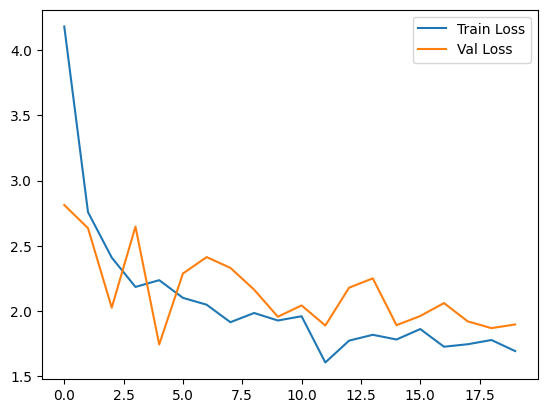

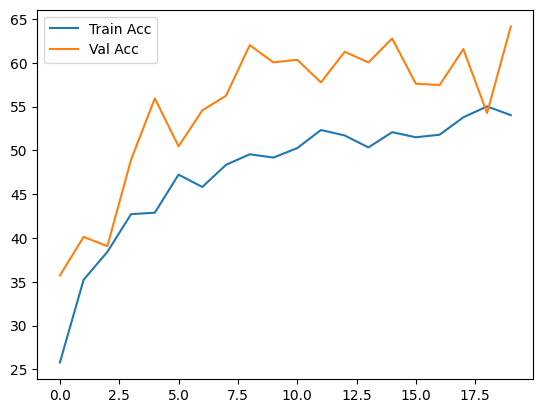

In [28]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [29]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_1e-3.pth")

In [30]:
with open("saved_models/ann-grey_lambda_1e-3_history.pkl", "wb") as f:
    pickle.dump(history, f)

Ok let's try a number between 1e-4 and 1e-3

In [31]:
lamb = 0.0005
ann_model = ANN2()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 3.6964 | Val Loss: 3.0852 | Train Acc: 27.1523 | Val Acc: 35.7143
Epoch [2/20] Train Loss: 2.7263 | Val Loss: 2.5192 | Train Acc: 36.7964 | Val Acc: 39.3617
Epoch [3/20] Train Loss: 2.4339 | Val Loss: 2.2324 | Train Acc: 39.8179 | Val Acc: 47.1125
Epoch [4/20] Train Loss: 2.4900 | Val Loss: 3.2476 | Train Acc: 42.7566 | Val Acc: 50.6079
Epoch [5/20] Train Loss: 2.1659 | Val Loss: 2.5502 | Train Acc: 45.3228 | Val Acc: 57.1429
Epoch [6/20] Train Loss: 1.9470 | Val Loss: 1.9832 | Train Acc: 47.7235 | Val Acc: 58.5106
Epoch [7/20] Train Loss: 1.8660 | Val Loss: 2.0551 | Train Acc: 47.8477 | Val Acc: 59.1185
Epoch [8/20] Train Loss: 1.8702 | Val Loss: 2.1525 | Train Acc: 50.9934 | Val Acc: 52.1277
Epoch [9/20] Train Loss: 1.9099 | Val Loss: 1.9691 | Train Acc: 51.2417 | Val Acc: 60.0304
Epoch [10/20] Train Loss: 1.9101 | Val Loss: 2.2164 | Train Acc: 51.5315 | Val Acc: 60.1824
Epoch [11/20] Train Loss: 1.7415 | Val Loss: 2.1998 | Train Acc: 51.15

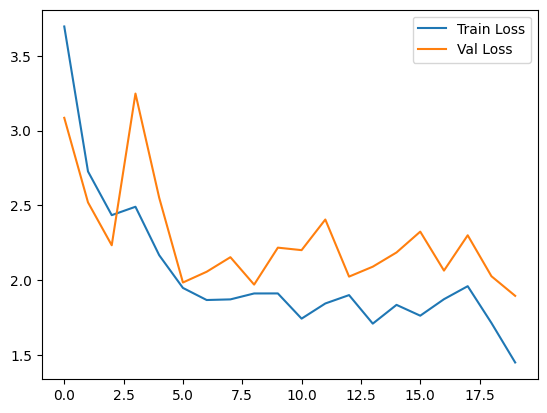

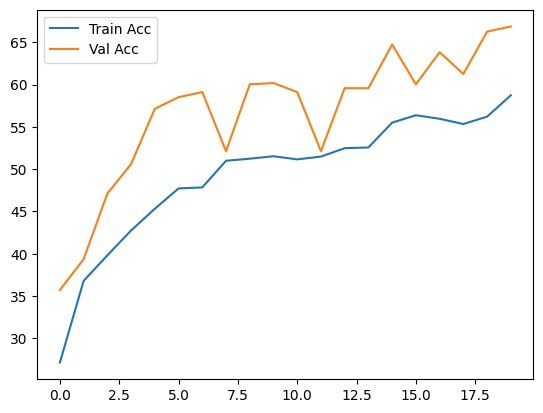

In [32]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [33]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-grey_lambda_5e-4.pth")

In [34]:
with open("saved_models/ann-grey_lambda_5e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

Seems like 5e-4 to 1e-4 is the right lambda

**2 Hidden Layers with Batch Normalisation**

In [4]:

eval_transform = train_transform = transforms.Compose([transforms.Resize((128, 128)), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                           std=[0.5, 0.5, 0.5]),                     
])

In [5]:
train_data = datasets.ImageFolder(os.path.join(DATA_PATH, "training"), transform=train_transform)
test_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "test"), transform=eval_transform)
val_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "validation"), transform=eval_transform)

print("Classes:", train_data.classes)
print("Number of Classes:", len(train_data.classes))
print("Training Samples:", len(train_data))
print("Val Samples:", len(val_data))
print("Test Samples:", len(test_data))
print("Total Samples:", len(train_data)+len(val_data)+len(test_data))

Classes: ['asteroid', 'black_hole', 'earth', 'galaxy', 'jupiter', 'mars', 'mercury', 'neptune', 'pluto', 'saturn', 'uranus', 'venus']
Number of Classes: 12
Training Samples: 2416
Val Samples: 658
Test Samples: 345
Total Samples: 3419


In [ ]:
class ANN3(nn.Module):
    def __init__(self, input_size = 3*128*128, num_classes = 12, dropout = 0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = ANN3().to(device)

In [8]:
def train_ann(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001, weight_decay=0.0001):
    model = ANN3().to(device)
    print("Training on: ", device)

    crieterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    weight_decay=weight_decay
    )
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(images)
            loss = crieterion(outputs, labels)

            loss.backward()
            optimiser.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted =  torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        avg_train_loss = running_loss/total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0 
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = crieterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100 * val_correct/val_total
        avg_val_loss = val_loss/val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
            f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        )
    print("Training_complete")
    return model, history

    

In [9]:
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True)

val_loader = DataLoader(val_data,
                        batch_size=32,
                        shuffle=False,
                        pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=False,
                         pin_memory=True)


In [15]:
ann_model = ANN3()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay=0.0001
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.4281 | Val Loss: 1.0259 | Train Acc: 55.5464 | Val Acc: 69.6049
Epoch [2/20] Train Loss: 0.9303 | Val Loss: 1.0999 | Train Acc: 71.3162 | Val Acc: 57.9027
Epoch [3/20] Train Loss: 0.7960 | Val Loss: 0.7838 | Train Acc: 75.2070 | Val Acc: 78.1155
Epoch [4/20] Train Loss: 0.6906 | Val Loss: 0.9664 | Train Acc: 78.0629 | Val Acc: 72.9483
Epoch [5/20] Train Loss: 0.6357 | Val Loss: 0.7366 | Train Acc: 80.2980 | Val Acc: 77.0517
Epoch [6/20] Train Loss: 0.5708 | Val Loss: 0.7318 | Train Acc: 82.4089 | Val Acc: 76.7477
Epoch [7/20] Train Loss: 0.5510 | Val Loss: 0.7927 | Train Acc: 82.4089 | Val Acc: 73.4043
Epoch [8/20] Train Loss: 0.5325 | Val Loss: 0.6664 | Train Acc: 83.5265 | Val Acc: 76.1398
Epoch [9/20] Train Loss: 0.5135 | Val Loss: 0.5848 | Train Acc: 84.1474 | Val Acc: 82.6748
Epoch [10/20] Train Loss: 0.4512 | Val Loss: 0.9427 | Train Acc: 86.5066 | Val Acc: 70.3647
Epoch [11/20] Train Loss: 0.4646 | Val Loss: 0.6410 | Train Acc: 84.43

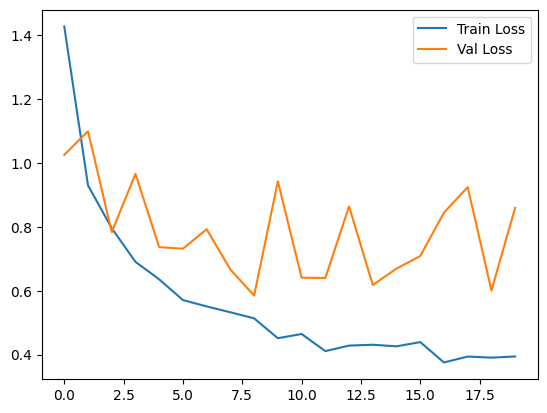

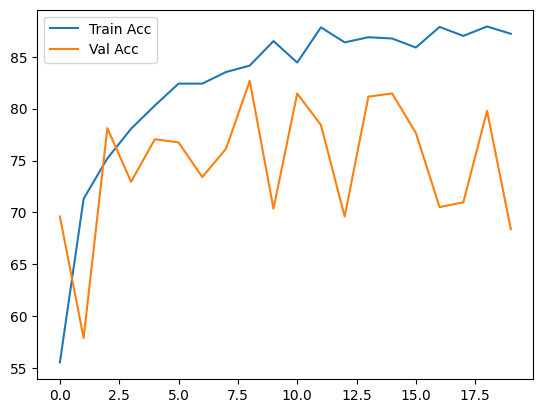

In [16]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [17]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-2_lambda_1e-4.pth")

In [18]:
with open("saved_models/ann-2_lambda_1e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

Since it's overfitting I want to add another dropout layer and increase lambda


In [ ]:
class ANN3(nn.Module):
    def __init__(self, input_size = 3*128*128, num_classes = 12, dropout = 0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [11]:
lamb = 0.0005
ann_model = ANN3()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay=lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.4918 | Val Loss: 1.2058 | Train Acc: 53.4354 | Val Acc: 62.4620
Epoch [2/20] Train Loss: 1.0295 | Val Loss: 1.1461 | Train Acc: 68.4189 | Val Acc: 60.9422
Epoch [3/20] Train Loss: 0.9029 | Val Loss: 0.8585 | Train Acc: 71.5232 | Val Acc: 74.6201
Epoch [4/20] Train Loss: 0.7885 | Val Loss: 0.8458 | Train Acc: 75.7450 | Val Acc: 76.4438
Epoch [5/20] Train Loss: 0.7676 | Val Loss: 0.9546 | Train Acc: 75.2483 | Val Acc: 67.0213
Epoch [6/20] Train Loss: 0.7197 | Val Loss: 0.8661 | Train Acc: 77.6490 | Val Acc: 73.2523
Epoch [7/20] Train Loss: 0.7249 | Val Loss: 0.8236 | Train Acc: 76.5728 | Val Acc: 71.7325
Epoch [8/20] Train Loss: 0.6837 | Val Loss: 0.8975 | Train Acc: 78.3526 | Val Acc: 68.9970
Epoch [9/20] Train Loss: 0.7090 | Val Loss: 0.9166 | Train Acc: 77.6076 | Val Acc: 71.4286
Epoch [10/20] Train Loss: 0.6418 | Val Loss: 0.9735 | Train Acc: 79.4702 | Val Acc: 68.2371
Epoch [11/20] Train Loss: 0.6643 | Val Loss: 0.8759 | Train Acc: 79.30

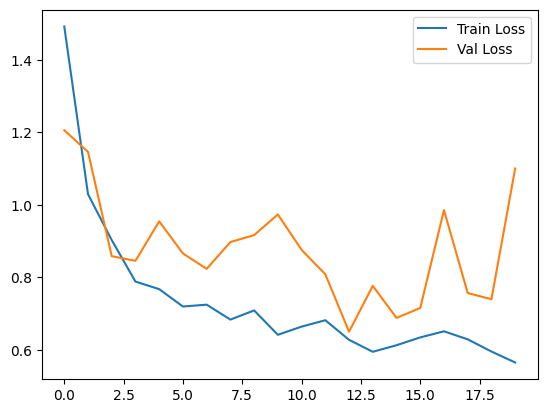

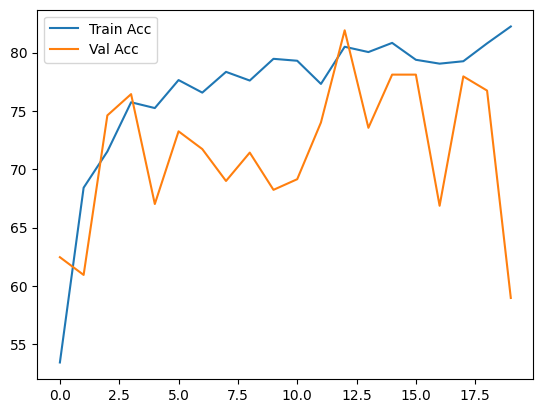

In [12]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [13]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-2_lambda_5e-4.pth")

In [14]:
with open("saved_models/ann-2_lambda_5e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

Overfitting so simplify model

In [ ]:
class ANN3(nn.Module):
    def __init__(self, input_size = 3*128*128, num_classes = 12, dropout = 0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [16]:
lamb = 0.0007
ann_model = ANN3()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay=lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.4608 | Val Loss: 1.1647 | Train Acc: 55.7119 | Val Acc: 66.5653
Epoch [2/20] Train Loss: 0.9876 | Val Loss: 1.0027 | Train Acc: 68.3361 | Val Acc: 68.6930
Epoch [3/20] Train Loss: 0.8480 | Val Loss: 0.9022 | Train Acc: 74.4205 | Val Acc: 70.8207
Epoch [4/20] Train Loss: 0.7552 | Val Loss: 0.8610 | Train Acc: 76.4901 | Val Acc: 68.8450
Epoch [5/20] Train Loss: 0.7313 | Val Loss: 0.7362 | Train Acc: 76.8626 | Val Acc: 78.2675
Epoch [6/20] Train Loss: 0.7149 | Val Loss: 1.0598 | Train Acc: 77.1109 | Val Acc: 63.8298
Epoch [7/20] Train Loss: 0.6725 | Val Loss: 0.8362 | Train Acc: 77.9801 | Val Acc: 72.9483
Epoch [8/20] Train Loss: 0.6269 | Val Loss: 0.8523 | Train Acc: 80.0497 | Val Acc: 71.4286
Epoch [9/20] Train Loss: 0.6507 | Val Loss: 0.8895 | Train Acc: 79.9669 | Val Acc: 67.7812
Epoch [10/20] Train Loss: 0.6610 | Val Loss: 0.7748 | Train Acc: 79.0563 | Val Acc: 74.1641
Epoch [11/20] Train Loss: 0.6253 | Val Loss: 0.9594 | Train Acc: 79.88

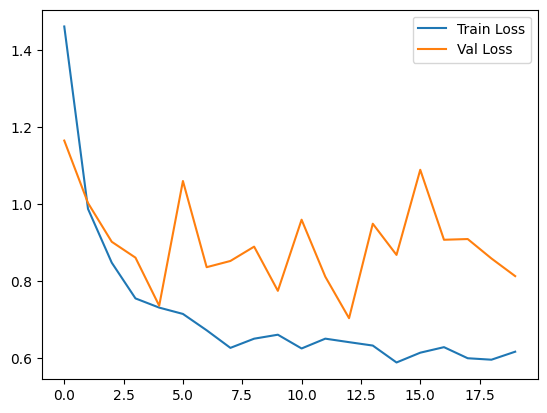

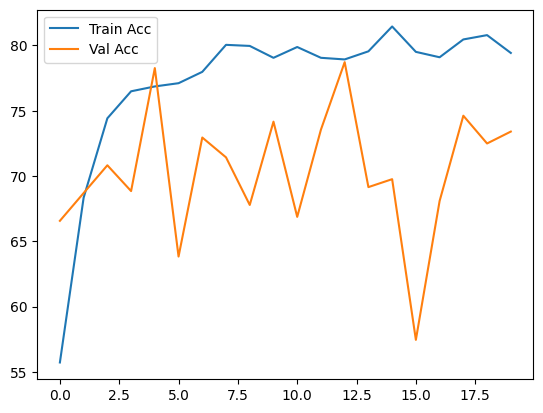

In [17]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [ ]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-2_lambda_7e-4.pth")

In [ ]:
with open("saved_models/ann-2_lambda_7e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

Let's increase lamb more

In [20]:
lamb = 0.007
ann_model = ANN3()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay=lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.4958 | Val Loss: 1.6375 | Train Acc: 53.1871 | Val Acc: 46.3526
Epoch [2/20] Train Loss: 1.0953 | Val Loss: 1.4382 | Train Acc: 67.2599 | Val Acc: 52.4316
Epoch [3/20] Train Loss: 1.0660 | Val Loss: 1.5032 | Train Acc: 66.6805 | Val Acc: 49.2401
Epoch [4/20] Train Loss: 1.0443 | Val Loss: 1.5172 | Train Acc: 67.0944 | Val Acc: 34.1945
Epoch [5/20] Train Loss: 0.9972 | Val Loss: 1.3603 | Train Acc: 68.5844 | Val Acc: 49.3921
Epoch [6/20] Train Loss: 0.9940 | Val Loss: 1.2317 | Train Acc: 68.5017 | Val Acc: 58.3587
Epoch [7/20] Train Loss: 0.9503 | Val Loss: 1.5966 | Train Acc: 70.1159 | Val Acc: 42.5532
Epoch [8/20] Train Loss: 0.9795 | Val Loss: 1.0777 | Train Acc: 68.3361 | Val Acc: 68.3891
Epoch [9/20] Train Loss: 0.9511 | Val Loss: 1.3507 | Train Acc: 69.8675 | Val Acc: 52.8875
Epoch [10/20] Train Loss: 0.9496 | Val Loss: 1.2752 | Train Acc: 70.0745 | Val Acc: 55.0152
Epoch [11/20] Train Loss: 0.9802 | Val Loss: 1.8532 | Train Acc: 68.54

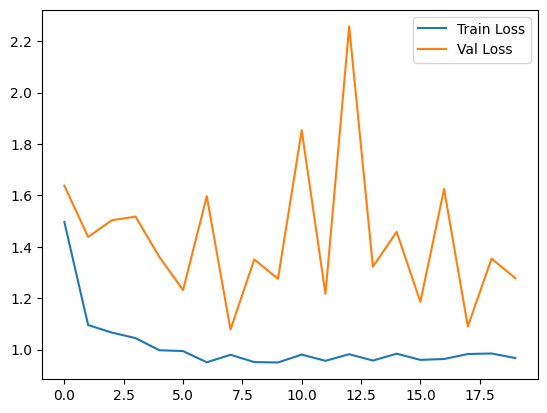

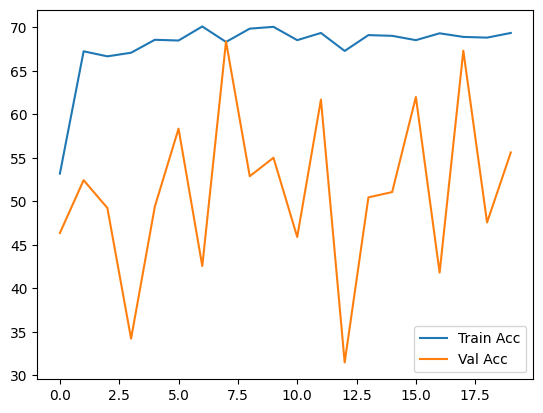

In [ ]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [22]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-2_lambda_7e-3.pth")

In [23]:
with open("saved_models/ann-2_lambda_7e-3_history.pkl", "wb") as f:
    pickle.dump(history, f)

The accuracy dropped let's lower the lambda

In [ ]:
lamb = 0.001
ann_model = ANN3()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay=lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.5005 | Val Loss: 1.2682 | Train Acc: 52.3593 | Val Acc: 55.3191
Epoch [2/20] Train Loss: 1.0229 | Val Loss: 1.0923 | Train Acc: 66.6805 | Val Acc: 72.6444
Epoch [3/20] Train Loss: 0.8978 | Val Loss: 1.0064 | Train Acc: 71.4818 | Val Acc: 69.9088
Epoch [4/20] Train Loss: 0.8290 | Val Loss: 1.6550 | Train Acc: 73.5513 | Val Acc: 47.4164
Epoch [5/20] Train Loss: 0.7928 | Val Loss: 1.2441 | Train Acc: 74.5447 | Val Acc: 56.5350
Epoch [6/20] Train Loss: 0.7621 | Val Loss: 0.8538 | Train Acc: 75.7450 | Val Acc: 75.8359
Epoch [7/20] Train Loss: 0.7614 | Val Loss: 0.9690 | Train Acc: 75.9106 | Val Acc: 63.6778
Epoch [8/20] Train Loss: 0.7295 | Val Loss: 1.0665 | Train Acc: 76.8212 | Val Acc: 64.4377
Epoch [9/20] Train Loss: 0.7226 | Val Loss: 0.8234 | Train Acc: 75.7450 | Val Acc: 76.4438
Epoch [10/20] Train Loss: 0.7029 | Val Loss: 1.1128 | Train Acc: 77.7318 | Val Acc: 57.1429
Epoch [11/20] Train Loss: 0.7106 | Val Loss: 0.8553 | Train Acc: 76.82

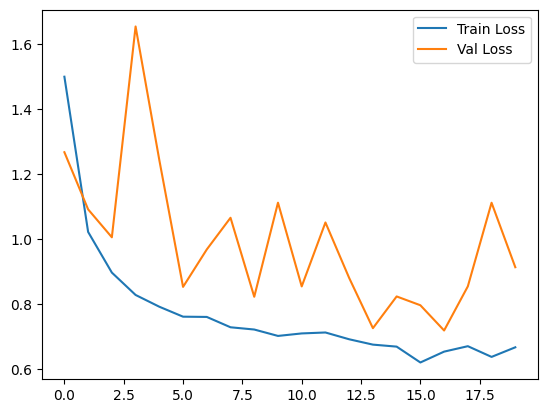

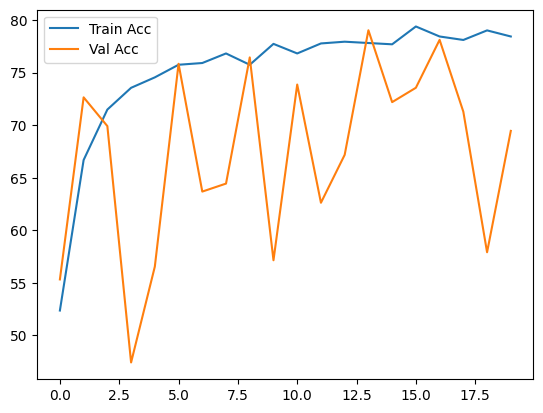

In [25]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [26]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-2_lambda_1e-3.pth")

In [27]:
with open("saved_models/ann-2_lambda_1e-3_history.pkl", "wb") as f:
    pickle.dump(history, f)

Let's try 2e-3 and reduce the epochs to 15

In [28]:
lamb = 0.002
ann_model = ANN3()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=15,
    learning_rate=0.001,
    weight_decay=lamb
)

Training on:  cuda
Epoch [1/15] Train Loss: 1.5039 | Val Loss: 1.2183 | Train Acc: 54.3460 | Val Acc: 63.0699
Epoch [2/15] Train Loss: 1.0254 | Val Loss: 1.2252 | Train Acc: 68.7086 | Val Acc: 57.2948
Epoch [3/15] Train Loss: 0.9308 | Val Loss: 1.0699 | Train Acc: 70.7781 | Val Acc: 60.9422
Epoch [4/15] Train Loss: 0.8592 | Val Loss: 0.9488 | Train Acc: 72.6821 | Val Acc: 65.9574
Epoch [5/15] Train Loss: 0.8746 | Val Loss: 1.0867 | Train Acc: 72.1854 | Val Acc: 64.7416
Epoch [6/15] Train Loss: 0.8610 | Val Loss: 0.8779 | Train Acc: 72.1026 | Val Acc: 75.3799
Epoch [7/15] Train Loss: 0.7901 | Val Loss: 1.0660 | Train Acc: 75.1656 | Val Acc: 62.1581
Epoch [8/15] Train Loss: 0.8146 | Val Loss: 1.4876 | Train Acc: 73.6755 | Val Acc: 51.8237
Epoch [9/15] Train Loss: 0.7848 | Val Loss: 0.9181 | Train Acc: 74.0480 | Val Acc: 71.1246
Epoch [10/15] Train Loss: 0.7802 | Val Loss: 1.0609 | Train Acc: 74.3791 | Val Acc: 69.6049
Epoch [11/15] Train Loss: 0.7935 | Val Loss: 0.8709 | Train Acc: 74.79

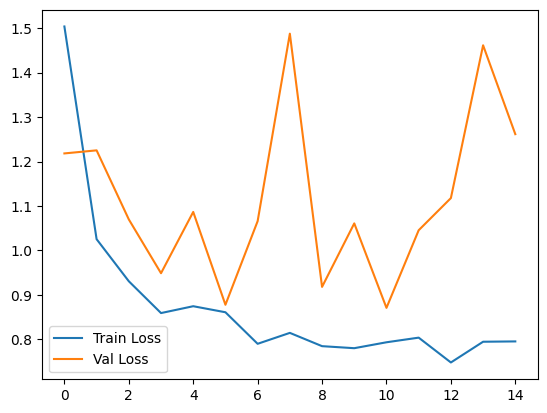

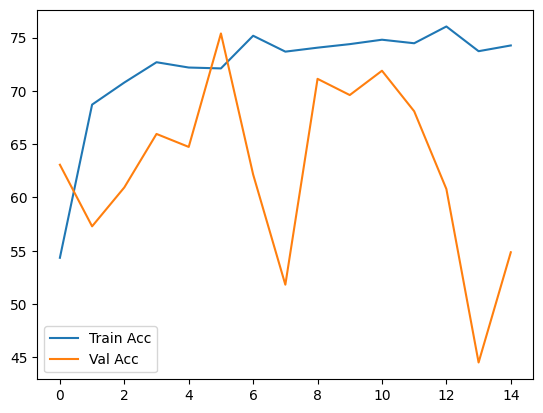

In [29]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

Well that was a complete fail

In [30]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-2_lambda_2e-3.pth")

In [31]:
with open("saved_models/ann-2_lambda_2e-3_history.pkl", "wb") as f:
    pickle.dump(history, f)

**3 LAYERS**

In [4]:

eval_transform = train_transform = transforms.Compose([transforms.Resize((128, 128)), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5], 
                                                           std=[0.5, 0.5, 0.5]),                     
])

In [5]:
train_data = datasets.ImageFolder(os.path.join(DATA_PATH, "training"), transform=train_transform)
test_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "test"), transform=eval_transform)
val_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "validation"), transform=eval_transform)

print("Classes:", train_data.classes)
print("Number of Classes:", len(train_data.classes))
print("Training Samples:", len(train_data))
print("Val Samples:", len(val_data))
print("Test Samples:", len(test_data))
print("Total Samples:", len(train_data)+len(val_data)+len(test_data))

Classes: ['asteroid', 'black_hole', 'earth', 'galaxy', 'jupiter', 'mars', 'mercury', 'neptune', 'pluto', 'saturn', 'uranus', 'venus']
Number of Classes: 12
Training Samples: 2416
Val Samples: 658
Test Samples: 345
Total Samples: 3419


In [6]:
class ANN4(nn.Module):
    def __init__(self, input_size = 3*128*128, num_classes = 12, dropout = 0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [7]:
train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=True,
                          pin_memory=True)

val_loader = DataLoader(val_data,
                        batch_size=32,
                        shuffle=False,
                        pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=32,
                         shuffle=False,
                         pin_memory=True)


In [8]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model = ANN4().to(device)

In [11]:
def train_ann(model, train_loader, val_loader, device, num_epochs=10, learning_rate=0.001, weight_decay=0.0001):
    model = ANN4().to(device)
    print("Training on: ", device)

    crieterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(
    model.parameters(),
    lr = learning_rate,
    weight_decay=weight_decay
    )
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(images)
            loss = crieterion(outputs, labels)

            loss.backward()
            optimiser.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted =  torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_acc = 100 * correct / total
        avg_train_loss = running_loss/total

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0 
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = crieterion(outputs, labels)
                val_loss += loss.item() * labels.size(0)
                
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        val_acc = 100 * val_correct/val_total
        avg_val_loss = val_loss/val_total

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
            f"| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}"
        )
    print("Training_complete")
    return model, history

    

In [12]:
lamb = 0.001
ann_model = ANN4()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.7248 | Val Loss: 1.2084 | Train Acc: 45.0331 | Val Acc: 65.3495
Epoch [2/20] Train Loss: 1.1376 | Val Loss: 1.4067 | Train Acc: 64.1556 | Val Acc: 51.5198
Epoch [3/20] Train Loss: 0.9938 | Val Loss: 0.9642 | Train Acc: 67.3841 | Val Acc: 72.3404
Epoch [4/20] Train Loss: 0.8902 | Val Loss: 0.8620 | Train Acc: 70.9437 | Val Acc: 69.4529
Epoch [5/20] Train Loss: 0.8531 | Val Loss: 0.7670 | Train Acc: 71.8129 | Val Acc: 77.6596
Epoch [6/20] Train Loss: 0.8651 | Val Loss: 0.8287 | Train Acc: 71.9371 | Val Acc: 74.1641
Epoch [7/20] Train Loss: 0.8268 | Val Loss: 0.9388 | Train Acc: 73.6341 | Val Acc: 68.9970
Epoch [8/20] Train Loss: 0.8060 | Val Loss: 0.8161 | Train Acc: 73.0960 | Val Acc: 72.4924
Epoch [9/20] Train Loss: 0.7914 | Val Loss: 0.7885 | Train Acc: 73.1374 | Val Acc: 75.5319
Epoch [10/20] Train Loss: 0.7506 | Val Loss: 0.7290 | Train Acc: 74.8758 | Val Acc: 78.4195
Epoch [11/20] Train Loss: 0.7132 | Val Loss: 0.8279 | Train Acc: 76.65

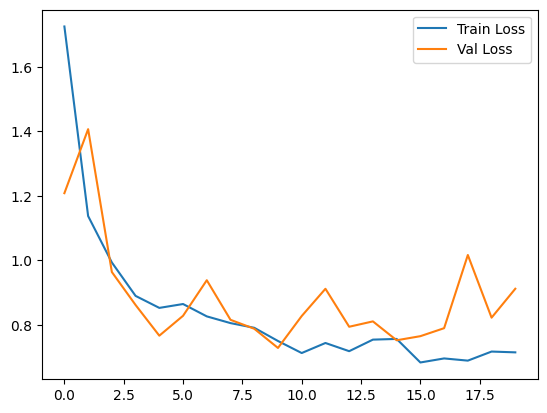

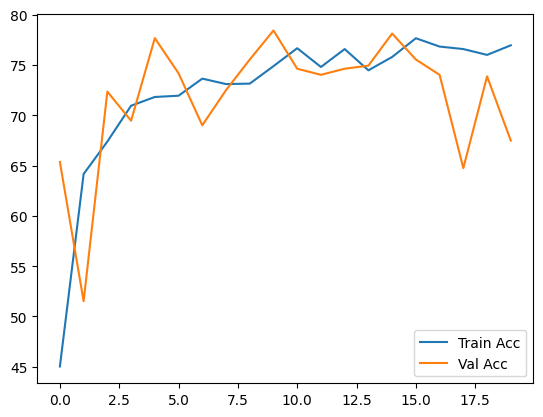

In [13]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [14]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-3_lambda_1e-3.pth")

In [15]:
with open("saved_models/ann-3_lambda_1e-3_history.pkl", "wb") as f:
    pickle.dump(history, f)

We still see volatility so overfitting let's try a larger lambda

In [16]:
lamb = 0.01
ann_model = ANN4()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.6347 | Val Loss: 1.5297 | Train Acc: 50.6209 | Val Acc: 50.7599
Epoch [2/20] Train Loss: 1.1957 | Val Loss: 1.2852 | Train Acc: 62.7897 | Val Acc: 63.2219
Epoch [3/20] Train Loss: 1.1343 | Val Loss: 1.4607 | Train Acc: 63.9487 | Val Acc: 46.6565
Epoch [4/20] Train Loss: 1.0801 | Val Loss: 1.5184 | Train Acc: 63.7003 | Val Acc: 47.2644
Epoch [5/20] Train Loss: 1.0735 | Val Loss: 1.7300 | Train Acc: 63.9901 | Val Acc: 33.2827
Epoch [6/20] Train Loss: 1.0598 | Val Loss: 1.4543 | Train Acc: 64.4868 | Val Acc: 49.8480
Epoch [7/20] Train Loss: 1.0760 | Val Loss: 1.2844 | Train Acc: 65.3974 | Val Acc: 62.6140
Epoch [8/20] Train Loss: 1.0346 | Val Loss: 1.8091 | Train Acc: 65.9354 | Val Acc: 36.9301
Epoch [9/20] Train Loss: 1.0514 | Val Loss: 1.5593 | Train Acc: 65.4801 | Val Acc: 45.2888
Epoch [10/20] Train Loss: 1.0518 | Val Loss: 1.6774 | Train Acc: 64.7351 | Val Acc: 39.6657
Epoch [11/20] Train Loss: 1.0239 | Val Loss: 1.5653 | Train Acc: 67.25

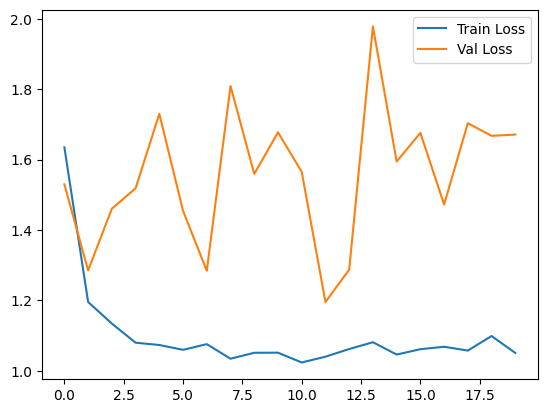

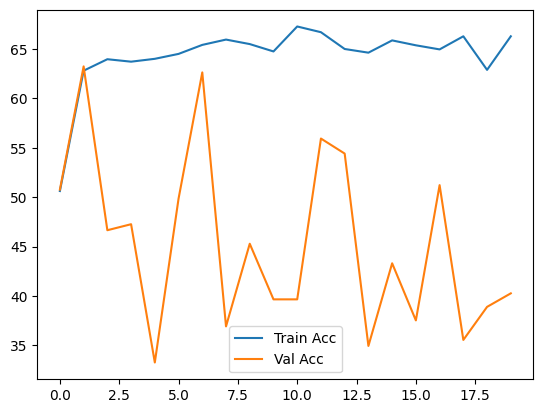

In [17]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [18]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-3_lambda_1e-2.pth")

In [19]:
with open("saved_models/ann-3_lambda_1e-2_history.pkl", "wb") as f:
    pickle.dump(history, f)

too much of a difference between both lambdas let's try 5e-3

In [20]:
lamb = 0.005
ann_model = ANN4()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.6709 | Val Loss: 1.3970 | Train Acc: 45.2401 | Val Acc: 51.5198
Epoch [2/20] Train Loss: 1.1653 | Val Loss: 1.2520 | Train Acc: 63.4934 | Val Acc: 62.3100
Epoch [3/20] Train Loss: 1.0392 | Val Loss: 1.0603 | Train Acc: 66.7632 | Val Acc: 64.4377
Epoch [4/20] Train Loss: 1.0294 | Val Loss: 1.1764 | Train Acc: 66.5149 | Val Acc: 58.2067
Epoch [5/20] Train Loss: 1.0185 | Val Loss: 1.1751 | Train Acc: 66.7219 | Val Acc: 59.2705
Epoch [6/20] Train Loss: 0.9741 | Val Loss: 1.4433 | Train Acc: 68.0050 | Val Acc: 46.3526
Epoch [7/20] Train Loss: 0.9627 | Val Loss: 1.8750 | Train Acc: 68.7086 | Val Acc: 26.7477
Epoch [8/20] Train Loss: 0.9454 | Val Loss: 1.0755 | Train Acc: 68.5844 | Val Acc: 63.9818
Epoch [9/20] Train Loss: 0.9341 | Val Loss: 1.3959 | Train Acc: 70.0331 | Val Acc: 46.5046
Epoch [10/20] Train Loss: 0.9310 | Val Loss: 1.2565 | Train Acc: 68.9983 | Val Acc: 57.7508
Epoch [11/20] Train Loss: 0.9327 | Val Loss: 1.2358 | Train Acc: 69.45

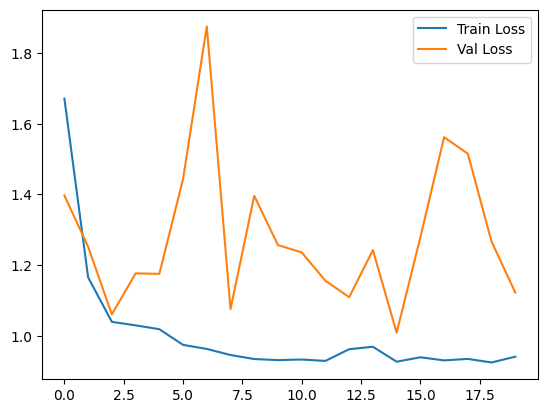

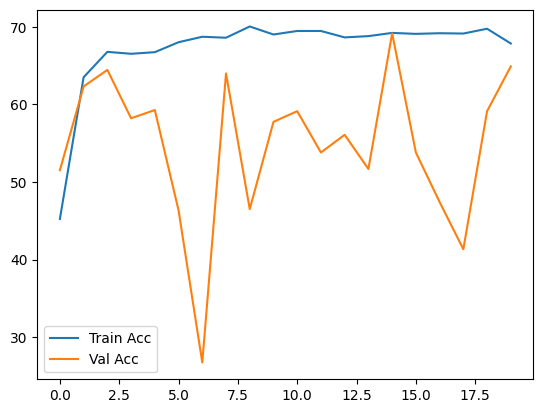

In [21]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [22]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-3_lambda_5e-3.pth")

In [23]:
with open("saved_models/ann-3_lambda_5e-3_history.pkl", "wb") as f:
    pickle.dump(history, f)

Let's go back to the learning rate around 1e-3 so let's try 9.5e-4. but reduce the learning rate

In [24]:
lamb = 0.00095
ann_model = ANN4()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.0001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.9715 | Val Loss: 1.6357 | Train Acc: 41.4321 | Val Acc: 61.2462
Epoch [2/20] Train Loss: 1.5275 | Val Loss: 1.3679 | Train Acc: 61.5066 | Val Acc: 71.1246
Epoch [3/20] Train Loss: 1.2851 | Val Loss: 1.2352 | Train Acc: 67.9636 | Val Acc: 72.9483
Epoch [4/20] Train Loss: 1.1245 | Val Loss: 1.0728 | Train Acc: 73.3858 | Val Acc: 75.2280
Epoch [5/20] Train Loss: 1.0122 | Val Loss: 0.9391 | Train Acc: 76.4073 | Val Acc: 78.1155
Epoch [6/20] Train Loss: 0.9117 | Val Loss: 0.9215 | Train Acc: 78.0215 | Val Acc: 79.7872
Epoch [7/20] Train Loss: 0.8315 | Val Loss: 0.8298 | Train Acc: 79.9669 | Val Acc: 83.5866
Epoch [8/20] Train Loss: 0.7617 | Val Loss: 0.8213 | Train Acc: 82.2020 | Val Acc: 83.8906
Epoch [9/20] Train Loss: 0.7069 | Val Loss: 0.7532 | Train Acc: 84.0232 | Val Acc: 77.8116
Epoch [10/20] Train Loss: 0.6529 | Val Loss: 0.6951 | Train Acc: 84.6854 | Val Acc: 83.4347
Epoch [11/20] Train Loss: 0.6150 | Val Loss: 0.6895 | Train Acc: 85.51

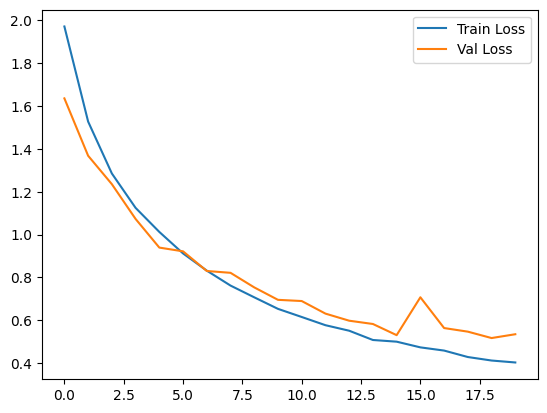

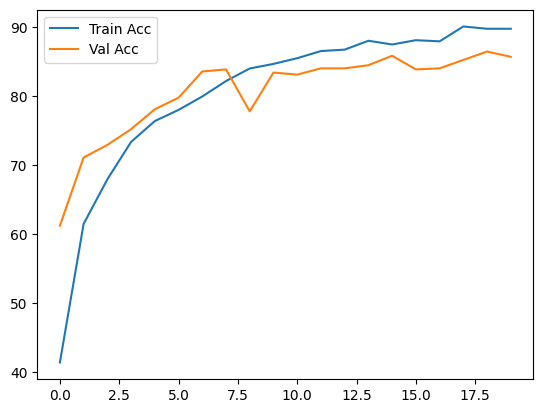

In [25]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [26]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-3_lambda_9_5e-4.pth")

In [27]:
with open("saved_models/ann-3_lambda_9_5e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

This is brilliant reducing the learning rate gave us a beuatifully smooth graph

Since we have probably found the most optimal model let's try a smaller lambda

In [28]:
lamb = 0.0001
ann_model = ANN4()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.0001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 2.0027 | Val Loss: 1.6251 | Train Acc: 36.7550 | Val Acc: 56.8389
Epoch [2/20] Train Loss: 1.5500 | Val Loss: 1.3778 | Train Acc: 59.7268 | Val Acc: 64.1337
Epoch [3/20] Train Loss: 1.2989 | Val Loss: 1.2415 | Train Acc: 69.5778 | Val Acc: 72.9483
Epoch [4/20] Train Loss: 1.1404 | Val Loss: 1.0350 | Train Acc: 73.0546 | Val Acc: 77.5076
Epoch [5/20] Train Loss: 1.0165 | Val Loss: 0.9698 | Train Acc: 76.2831 | Val Acc: 78.4195
Epoch [6/20] Train Loss: 0.9209 | Val Loss: 0.8717 | Train Acc: 77.8974 | Val Acc: 79.3313
Epoch [7/20] Train Loss: 0.8145 | Val Loss: 0.7733 | Train Acc: 81.8295 | Val Acc: 82.2188
Epoch [8/20] Train Loss: 0.7774 | Val Loss: 0.7840 | Train Acc: 80.8775 | Val Acc: 82.3708
Epoch [9/20] Train Loss: 0.7254 | Val Loss: 0.7372 | Train Acc: 82.5745 | Val Acc: 80.5471
Epoch [10/20] Train Loss: 0.6515 | Val Loss: 0.6968 | Train Acc: 83.7748 | Val Acc: 84.4985
Epoch [11/20] Train Loss: 0.6176 | Val Loss: 0.7081 | Train Acc: 86.34

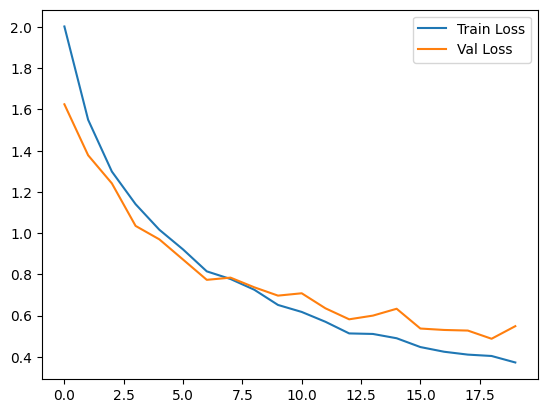

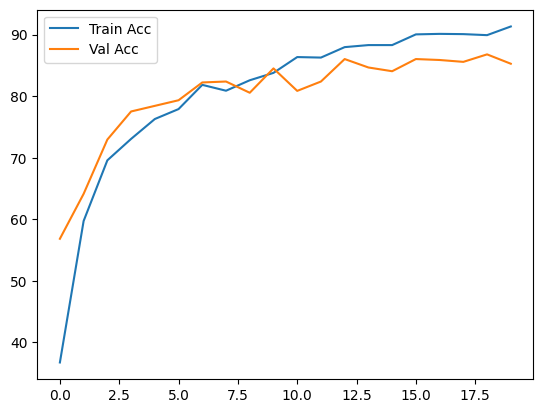

In [29]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [30]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-3_lambda_1e-4.pth")

In [31]:
with open("saved_models/ann-3_lambda_1e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

let's try with no lambda

In [32]:
lamb = 0
ann_model = ANN4()
trained_ann = train_ann(
    ann_model,
    train_loader,
    val_loader,
    device,
    num_epochs=20,
    learning_rate=0.0001,
    weight_decay = lamb
)

Training on:  cuda
Epoch [1/20] Train Loss: 1.9916 | Val Loss: 1.6609 | Train Acc: 40.5629 | Val Acc: 63.9818
Epoch [2/20] Train Loss: 1.5257 | Val Loss: 1.4010 | Train Acc: 62.5828 | Val Acc: 72.1884
Epoch [3/20] Train Loss: 1.2804 | Val Loss: 1.1893 | Train Acc: 69.1225 | Val Acc: 74.0122
Epoch [4/20] Train Loss: 1.1268 | Val Loss: 1.0250 | Train Acc: 73.4685 | Val Acc: 76.7477
Epoch [5/20] Train Loss: 0.9910 | Val Loss: 0.9102 | Train Acc: 76.3245 | Val Acc: 80.6991
Epoch [6/20] Train Loss: 0.9086 | Val Loss: 0.8857 | Train Acc: 79.1805 | Val Acc: 80.8511
Epoch [7/20] Train Loss: 0.8230 | Val Loss: 0.7955 | Train Acc: 80.6291 | Val Acc: 80.0912
Epoch [8/20] Train Loss: 0.7421 | Val Loss: 0.8072 | Train Acc: 83.0298 | Val Acc: 82.0669
Epoch [9/20] Train Loss: 0.6906 | Val Loss: 0.7209 | Train Acc: 84.0646 | Val Acc: 82.5228
Epoch [10/20] Train Loss: 0.6436 | Val Loss: 0.7218 | Train Acc: 84.9752 | Val Acc: 81.4590
Epoch [11/20] Train Loss: 0.6000 | Val Loss: 0.7035 | Train Acc: 85.30

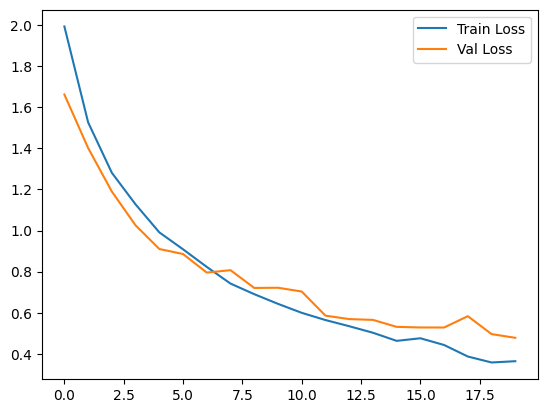

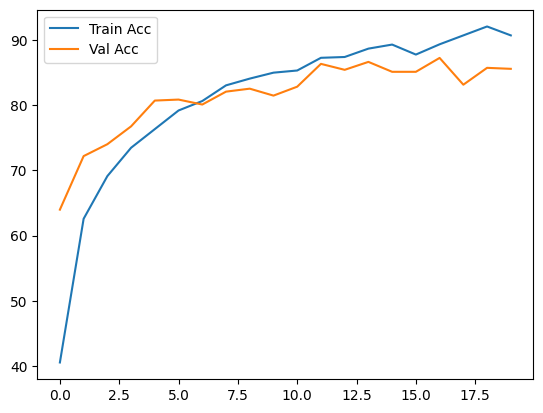

In [33]:
history = trained_ann[1]

plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend()
plt.show()

plt.plot(history["train_accuracy"], label="Train Acc")
plt.plot(history["val_accuracy"], label="Val Acc")
plt.legend()
plt.show()

In [34]:
torch.save(trained_ann[0].state_dict(),"saved_models/ann-3_lambda_0.pth")

In [35]:
with open("saved_models/ann-3_lambda_1e-4_history.pkl", "wb") as f:
    pickle.dump(history, f)

**METRICS**

In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd

In [52]:
class ANN3_1(nn.Module):
    def __init__(self, input_size = 3*128*128, num_classes = 12, dropout = 0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [53]:
class ANN3_2(nn.Module):
    def __init__(self, input_size = 3*128*128, num_classes = 12, dropout = 0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [54]:
class ANN3_3(nn.Module):
    def __init__(self, input_size = 3*128*128, num_classes = 12, dropout = 0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)

In [79]:
def get_metrics(model, loader, device, model_name):
    print(f"Evaluating {model_name}...", end=" ")
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    print("Done.")
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Precision": precision_score(all_labels, all_preds, average='weighted', zero_division=0),
        "Recall": recall_score(all_labels, all_preds, average='weighted', zero_division=0),
        "F1 Score": f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    }

In [83]:
candidates = [
    # --- ANN 1  ---
    {"name": "ANN (L=0)",        "path": "saved_models/ann_lambda_0.pth",      "model_class": ANN},
    {"name": "ANN (L=1e-4)",     "path": "saved_models/ann_lambda_1e-4.pth",   "model_class": ANN},
    {"name": "ANN (L=5e-6)",     "path": "saved_models/ann_lambda_5e-6.pth",   "model_class": ANN},
    {"name": "ANN (L=1e-5)",     "path": "saved_models/ann_lambda_1e-5.pth",   "model_class": ANN},
    {"name": "ANN (L=5e-4)",     "path": "saved_models/ann_lambda_5e-4.pth",   "model_class": ANN},
    {"name": "ANN (L=1e-3)",     "path": "saved_models/ann_lambda_1e-3.pth",   "model_class": ANN},

    # --- ANN 2 ---
    {"name": "ANN2 (L=1e-4)", "path": "saved_models/ann-2_lambda_1e-4.pth", "model_class": ANN3_1},
    {"name": "ANN2 (L=5e-4)", "path": "saved_models/ann-2_lambda_5e-4.pth", "model_class": ANN3_2},
    {"name": "ANN2 (L=7e-4)", "path": "saved_models/ann-2_lambda_7e-4.pth", "model_class": ANN3_3},
    {"name": "ANN2 (L=1e-3)", "path": "saved_models/ann-2_lambda_1e-3.pth", "model_class": ANN3_3},
    {"name": "ANN2 (L=2e-3)", "path": "saved_models/ann-2_lambda_2e-3.pth", "model_class": ANN3_3},
    {"name": "ANN2 (L=7e-3)", "path": "saved_models/ann-2_lambda_7e-3.pth", "model_class": ANN3_3},

    # --- ANN 3 ---
    {"name": "ANN3 (L=1e-4)",   "path": "saved_models/ann-3_lambda_1e-4.pth",   "model_class": ANN4},
    {"name": "ANN3 (L=9.5e-4)", "path": "saved_models/ann-3_lambda_9_5e-4.pth", "model_class": ANN4},
    {"name": "ANN3 (L=1e-3)",   "path": "saved_models/ann-3_lambda_1e-3.pth",   "model_class": ANN4},
    {"name": "ANN3 (L=5e-3)",   "path": "saved_models/ann-3_lambda_5e-3.pth",   "model_class": ANN4},
    {"name": "ANN3 (L=1e-2)",   "path": "saved_models/ann-3_lambda_1e-2.pth",   "model_class": ANN4},
    {"name": "ANN3 (L=0)",      "path":"saved_models/ann-3_lambda_0.pth",       "model_class": ANN4}
]
candidates_g = [
     # --- ANN (Greyscale) ---
    {"name": "ANN Grey (L=1e-4)",   "path": "saved_models/ann-grey_lambda_1e-4.pth",   "model_class": ANN2},
    {"name": "ANN Grey (L=1e-5)",   "path": "saved_models/ann-grey_lambda_1e-5.pth",   "model_class": ANN2},
    {"name": "ANN Grey (L=5e-5)",   "path": "saved_models/ann-grey_lambda_5e-5.pth",   "model_class": ANN2},
    {"name": "ANN Grey (L=7.5e-5)", "path": "saved_models/ann-grey_lambda_7_5e-5.pth", "model_class": ANN2},
    {"name": "ANN Grey (L=1e-3)",   "path": "saved_models/ann-grey_lambda_1e-3.pth",   "model_class": ANN2},
    {"name": "ANN Grey (L=5e-4)",   "path": "saved_models/ann-grey_lambda_5e-4.pth",   "model_class": ANN2},
]

In [84]:
results = []

print(f"{'Model Name':<20} | {'Status':<15}") 
print("-" * 40)

for cand in candidates:
    try:
        model = cand["model_class"]().to(device)
        model.load_state_dict(torch.load(cand["path"]))
        # Run on the current (RGB) val_loader
        results.append(get_metrics(model, val_loader, device, cand["name"]))
    except Exception as e:
        print(f"Error evaluating {cand['name']}: {e}")

Model Name           | Status         
----------------------------------------
Evaluating ANN (L=0)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN (L=1e-4)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN (L=5e-6)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN (L=1e-5)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN (L=5e-4)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN (L=1e-3)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.


C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Evaluating ANN2 (L=1e-4)... Done.


C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Evaluating ANN2 (L=5e-4)... Done.
Evaluating ANN2 (L=7e-4)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN2 (L=1e-3)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN2 (L=2e-3)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN2 (L=7e-3)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.


C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Evaluating ANN3 (L=1e-4)... Done.


C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Evaluating ANN3 (L=9.5e-4)... Done.
Evaluating ANN3 (L=1e-3)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.


C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Evaluating ANN3 (L=5e-3)... Done.
Evaluating ANN3 (L=1e-2)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN3 (L=0)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\936620211.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.


In [85]:

eval_transform = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.Grayscale(num_output_channels=1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5], std=[0.5])                     
])
val_data  = datasets.ImageFolder(os.path.join(DATA_PATH, "validation"), transform=eval_transform)
val_loader = DataLoader(val_data,
                        batch_size=32,
                        shuffle=False,
                        pin_memory=True)

In [86]:
print(f"{'Model Name':<20} | {'Status':<15}")
print("-" * 40)

for cand in candidates_g:
    try:
        model = cand["model_class"]().to(device)
        model.load_state_dict(torch.load(cand["path"]))
        # Run on the current (RGB) val_loader
        results.append(get_metrics(model, val_loader, device, cand["name"]))
    except Exception as e:
        print(f"Error evaluating {cand['name']}: {e}")

Model Name           | Status         
----------------------------------------
Evaluating ANN Grey (L=1e-4)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\1489797541.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN Grey (L=1e-5)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\1489797541.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN Grey (L=5e-5)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\1489797541.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN Grey (L=7.5e-5)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\1489797541.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN Grey (L=1e-3)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\1489797541.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.
Evaluating ANN Grey (L=5e-4)... 

C:\Users\aarav\AppData\Local\Temp\ipykernel_25636\1489797541.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cand["path"]))


Done.


In [89]:
df = pd.DataFrame(results)
# Reorder columns for readability
cols = ["Model", "Accuracy", "F1 Score", "Precision", "Recall"]
df = df[cols].sort_values(by="F1 Score", ascending=False)

print("\n" + "="*50)
print("FINAL LEADERBOARD (Validation Set)")
print("="*50)
print(df.to_string(index=False))


FINAL LEADERBOARD (Validation Set)
              Model  Accuracy  F1 Score  Precision   Recall
       ANN (L=1e-3)  0.860182  0.861061   0.868593 0.860182
         ANN3 (L=0)  0.855623  0.856355   0.864397 0.855623
      ANN3 (L=1e-4)  0.852584  0.853720   0.860897 0.852584
    ANN3 (L=9.5e-4)  0.857143  0.853639   0.864240 0.857143
       ANN (L=1e-4)  0.759878  0.757540   0.777420 0.759878
          ANN (L=0)  0.737082  0.732274   0.762910 0.737082
       ANN (L=5e-6)  0.731003  0.722613   0.735464 0.731003
       ANN (L=5e-4)  0.724924  0.718958   0.753891 0.724924
      ANN2 (L=7e-4)  0.734043  0.718001   0.773537 0.734043
      ANN2 (L=1e-3)  0.694529  0.692199   0.776566 0.694529
      ANN3 (L=1e-3)  0.674772  0.683293   0.758978 0.674772
  ANN Grey (L=5e-4)  0.668693  0.663875   0.688799 0.668693
  ANN Grey (L=1e-4)  0.670213  0.659666   0.675184 0.670213
       ANN (L=1e-5)  0.668693  0.658380   0.703375 0.668693
ANN Grey (L=7.5e-5)  0.656535  0.645642   0.661086 0.656535
    

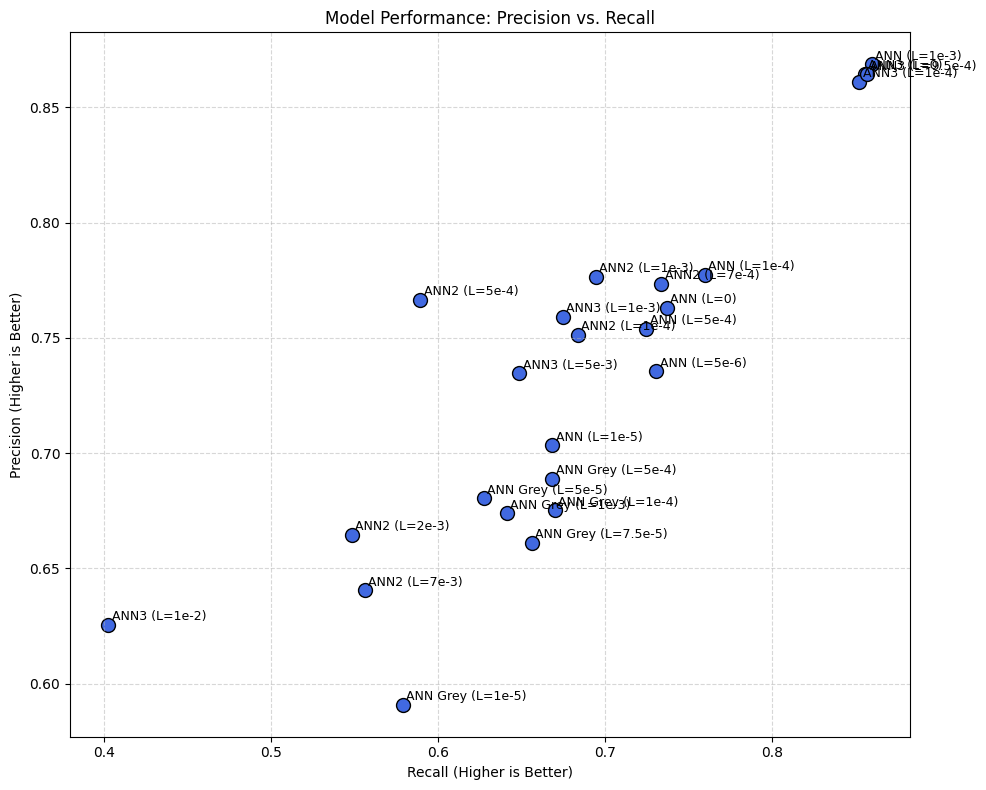

In [90]:
plt.figure(figsize=(10, 8))
plt.scatter(df['Recall'], df['Precision'], color='royalblue', s=100, edgecolors='black')
for i in range(len(df)):
    plt.text(x=df['Recall'].iloc[i] + 0.002, 
                y=df['Precision'].iloc[i] + 0.002, 
                s=df['Model'].iloc[i], 
                fontsize=9)
plt.title('Model Performance: Precision vs. Recall')
plt.xlabel('Recall (Higher is Better)')
plt.ylabel('Precision (Higher is Better)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()